TITANIC SURVIVAL PREDICTION GENERATOR
TRAINING FINAL MODEL FOR PREDICTIONS
Training data loaded. Shape: (891, 12)
Generating visualizations...


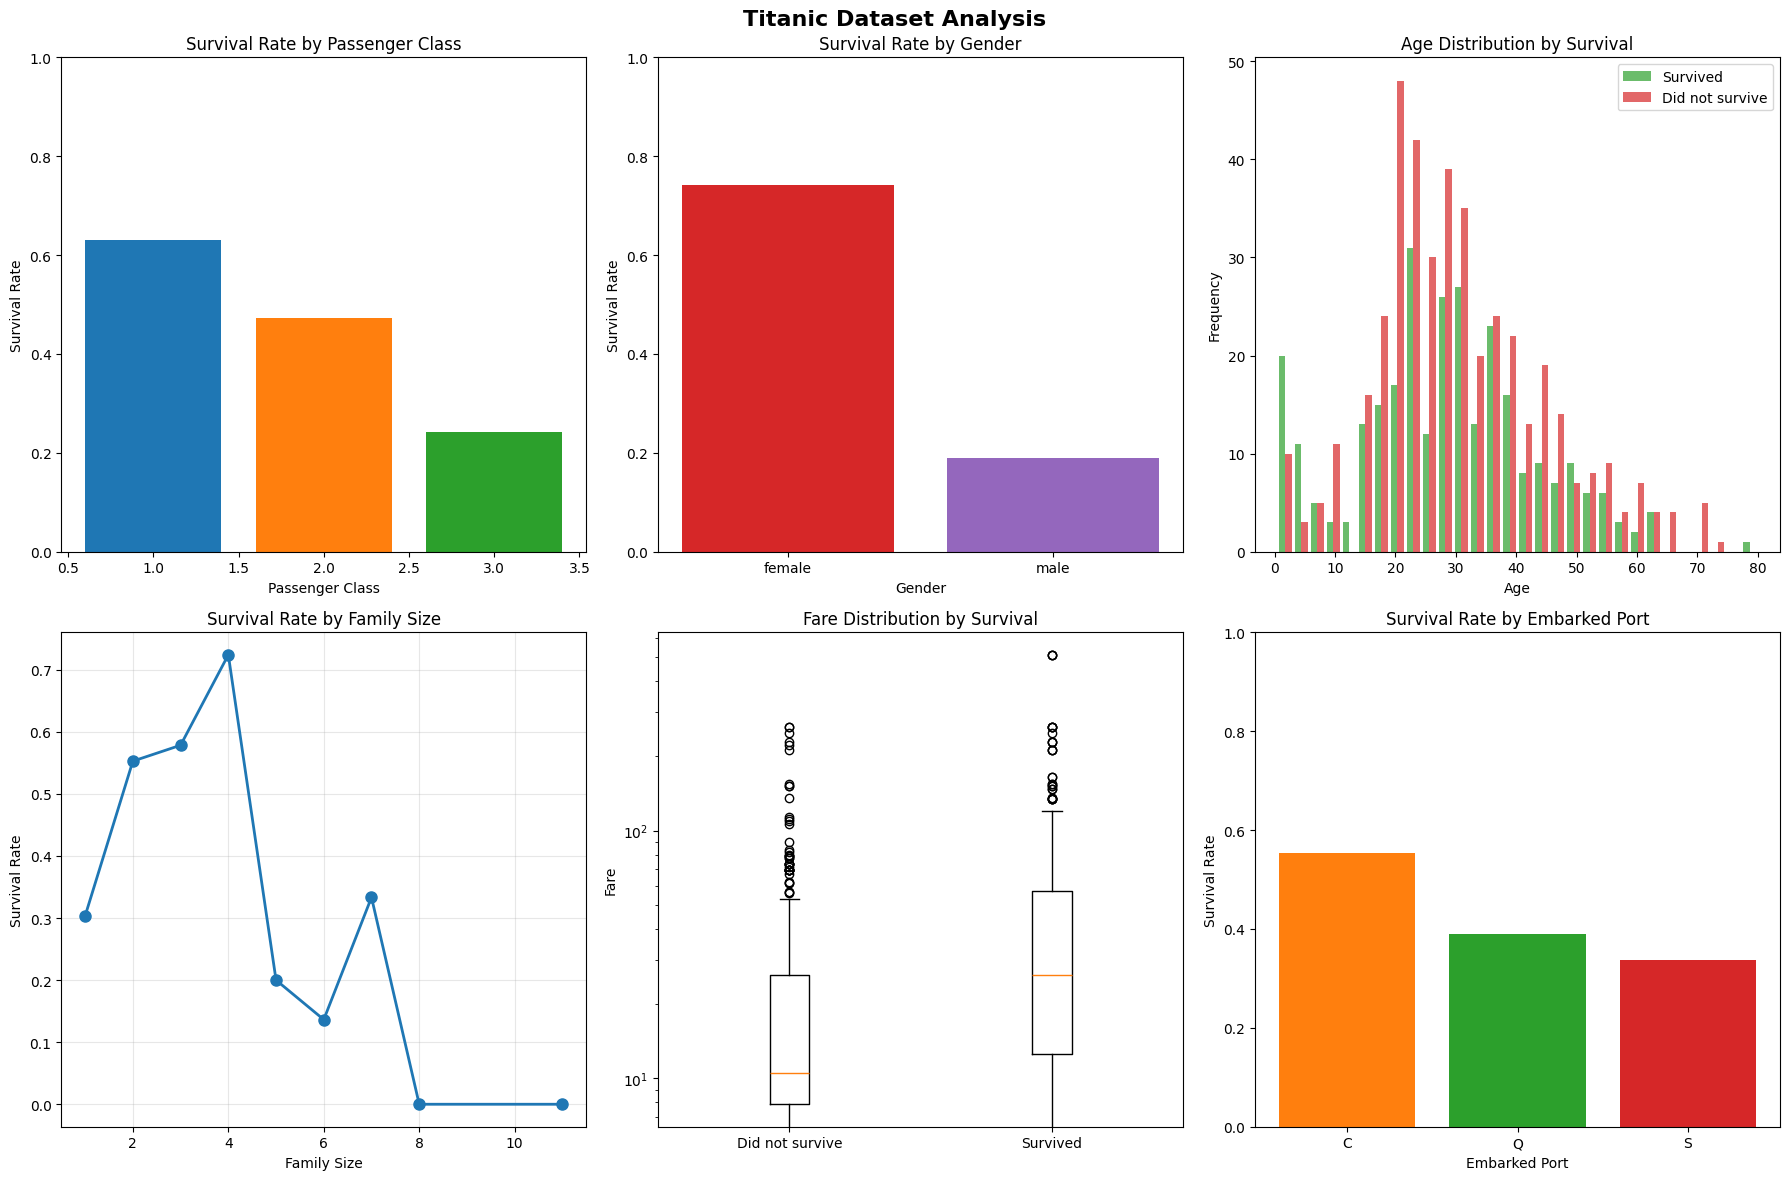

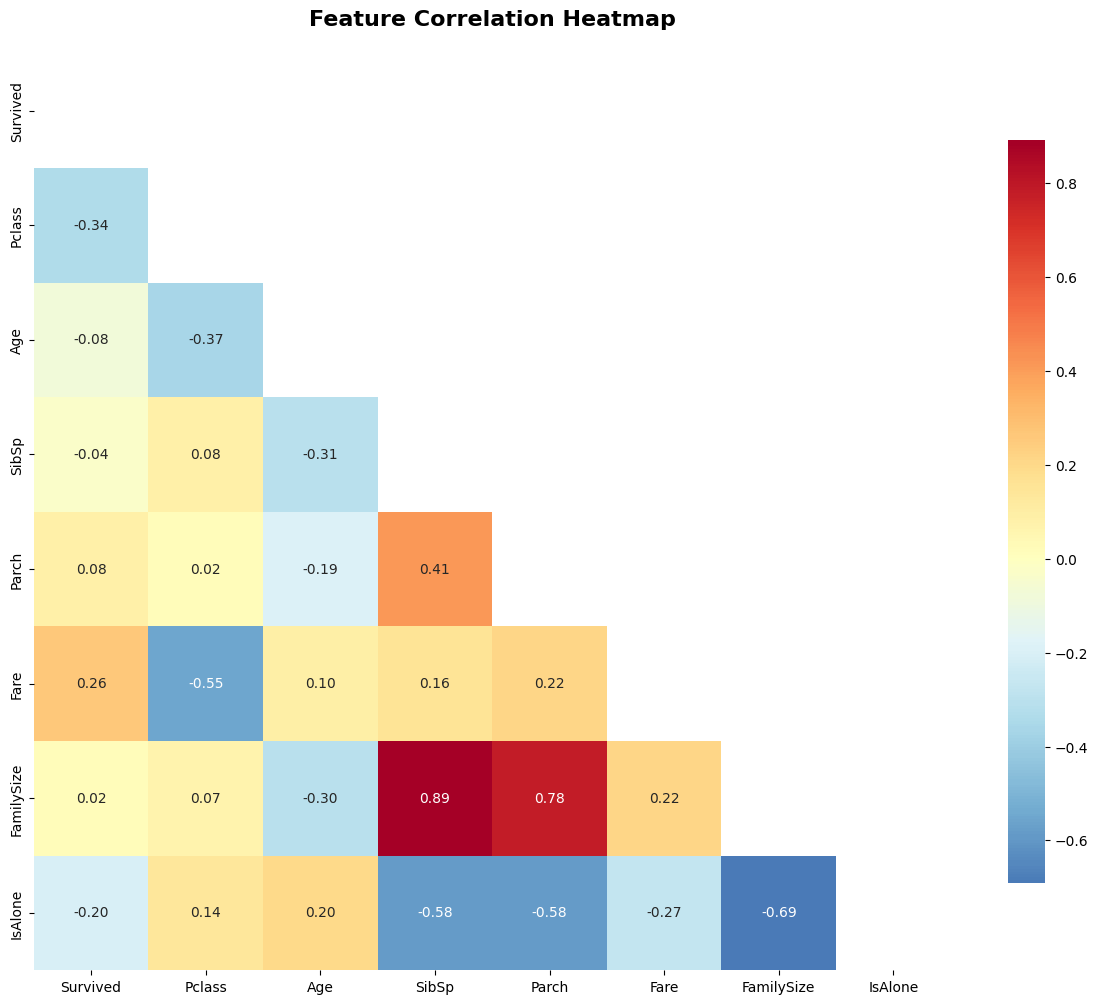

Training samples: 891
Training final model...
Evaluating model with cross-validation...
Cross-validation scores: [0.81564246 0.80337079 0.88202247 0.79213483 0.84269663]
Mean CV accuracy: 0.8272 (+/- 0.0644)
Final model training accuracy: 0.9371
Plotting feature importance...


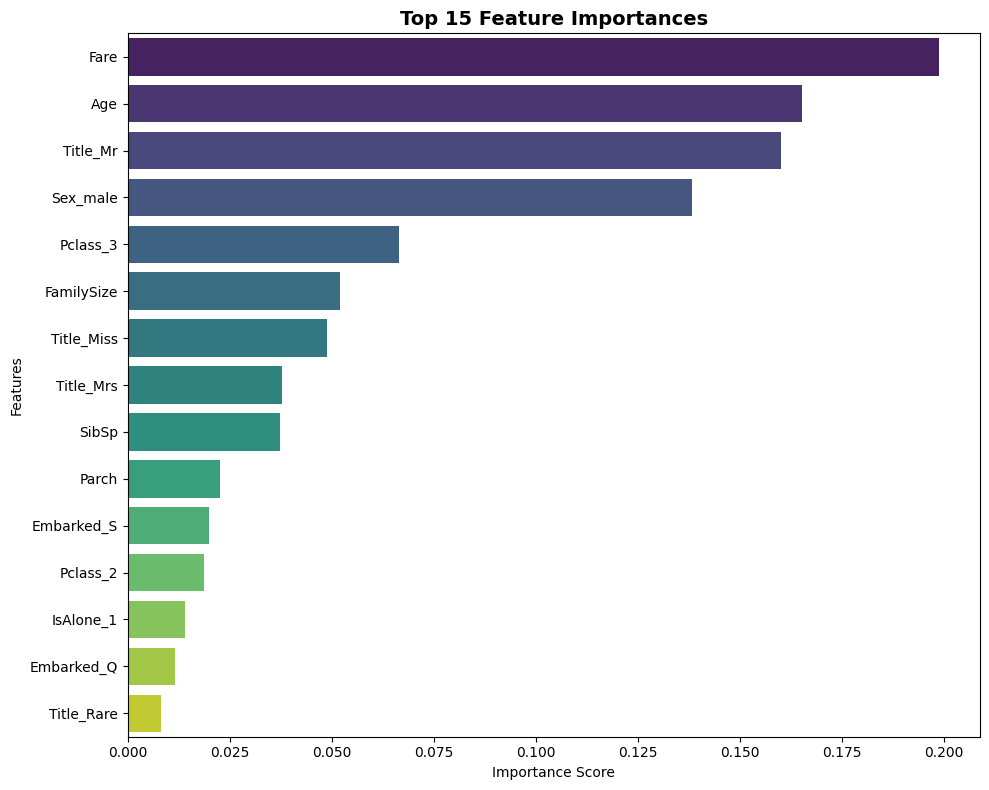


GENERATING PREDICTIONS
Test data loaded. Shape: (418, 11)
Test data info:
- Passengers: 418
- Features: 14
- Missing values: 414

Generating predictions...
Predictions generated successfully!
Predicted survival rate: 0.344
Predictions saved to 'titanic_predictions.csv'
Detailed predictions saved to 'titanic_predictions_detailed.csv'

Sample predictions:
   PassengerId  Survived  Probability_Not_Survived  Probability_Survived  \
0          892         0                  0.928422              0.071578   
1          893         0                  0.750639              0.249361   
2          894         0                  0.713519              0.286481   
3          895         0                  0.807476              0.192524   
4          896         0                  0.506309              0.493691   
5          897         0                  0.878819              0.121181   
6          898         0                  0.711355              0.288645   
7          899         0           

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

def engineer_features(df):
    df = df.copy()
    
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    try:
        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        
        rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 
                      'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
        df['Title'] = df['Title'].replace(rare_titles, 'Rare')
        df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')
        df['Title'] = df['Title'].fillna('Unknown')
    except:
        print("Warning: Could not extract titles from names")
        df['Title'] = 'Unknown'
    
    return df

def create_preprocessing_pipeline():
    numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
    categorical_features = ['Pclass', 'Sex', 'Embarked', 'IsAlone', 'Title']
    
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ], remainder='drop')
    
    return preprocessor

def visualize_data_analysis(df):
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Titanic Dataset Analysis', fontsize=16, fontweight='bold')
    
    survival_by_class = df.groupby('Pclass')['Survived'].mean()
    axes[0, 0].bar(survival_by_class.index, survival_by_class.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[0, 0].set_title('Survival Rate by Passenger Class')
    axes[0, 0].set_xlabel('Passenger Class')
    axes[0, 0].set_ylabel('Survival Rate')
    axes[0, 0].set_ylim(0, 1)
    
    survival_by_gender = df.groupby('Sex')['Survived'].mean()
    axes[0, 1].bar(survival_by_gender.index, survival_by_gender.values, color=['#d62728', '#9467bd'])
    axes[0, 1].set_title('Survival Rate by Gender')
    axes[0, 1].set_xlabel('Gender')
    axes[0, 1].set_ylabel('Survival Rate')
    axes[0, 1].set_ylim(0, 1)
    
    survivors = df[df['Survived'] == 1]['Age'].dropna()
    non_survivors = df[df['Survived'] == 0]['Age'].dropna()
    axes[0, 2].hist([survivors, non_survivors], bins=30, alpha=0.7, 
                   label=['Survived', 'Did not survive'], color=['#2ca02c', '#d62728'])
    axes[0, 2].set_title('Age Distribution by Survival')
    axes[0, 2].set_xlabel('Age')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].legend()
    
    family_survival = df.groupby('FamilySize')['Survived'].mean()
    axes[1, 0].plot(family_survival.index, family_survival.values, marker='o', linewidth=2, markersize=8)
    axes[1, 0].set_title('Survival Rate by Family Size')
    axes[1, 0].set_xlabel('Family Size')
    axes[1, 0].set_ylabel('Survival Rate')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].boxplot([df[df['Survived'] == 0]['Fare'].dropna(), 
                       df[df['Survived'] == 1]['Fare'].dropna()],
                      labels=['Did not survive', 'Survived'])
    axes[1, 1].set_title('Fare Distribution by Survival')
    axes[1, 1].set_ylabel('Fare')
    axes[1, 1].set_yscale('log')
 
    embarked_survival = df.groupby('Embarked')['Survived'].mean()
    axes[1, 2].bar(embarked_survival.index, embarked_survival.values, 
                   color=['#ff7f0e', '#2ca02c', '#d62728'])
    axes[1, 2].set_title('Survival Rate by Embarked Port')
    axes[1, 2].set_xlabel('Embarked Port')
    axes[1, 2].set_ylabel('Survival Rate')
    axes[1, 2].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def create_correlation_heatmap(df):
    plt.figure(figsize=(12, 10))

    numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']
    correlation_data = df[numeric_cols].corr()
    
    mask = np.triu(np.ones_like(correlation_data, dtype=bool))
    sns.heatmap(correlation_data, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    
    plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, X_sample):

    preprocessor = model.named_steps['preprocessor']
    
    feature_names = []
    
   
    numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
    feature_names.extend(numeric_features)
    
    for name, transformer, features in preprocessor.transformers_:
        if name == 'cat':
            onehot = transformer.named_steps['onehot']
            cat_feature_names = onehot.get_feature_names_out(features)
            feature_names.extend(cat_feature_names)
    
    importances = model.named_steps['classifier'].feature_importances_
    

    if len(feature_names) != len(importances):
        print(f"Warning: Feature name count ({len(feature_names)}) doesn't match importance count ({len(importances)})")
        feature_names = [f'Feature_{i}' for i in range(len(importances))]
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='viridis')
    plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    return importance_df

def evaluate_model_with_cv(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    return cv_scores

def train_final_model():
    print("TRAINING FINAL MODEL FOR PREDICTIONS")
    print("="*50)
    
    try:
        train_df = pd.read_csv('train.csv')
        print(f"Training data loaded. Shape: {train_df.shape}")
    except FileNotFoundError:
        print("Error: 'train.csv' file not found!")
        return None, None
    
    train_df_clean = train_df.dropna(subset=['Survived'])
    train_df_engineered = engineer_features(train_df_clean)
    
    print("Generating visualizations...")
    visualize_data_analysis(train_df_engineered)
    create_correlation_heatmap(train_df_engineered)
    
    X = train_df_engineered.drop(['Survived'], axis=1)
    y = train_df_engineered['Survived']
    
    print(f"Training samples: {len(X)}")
    
    preprocessor = create_preprocessing_pipeline()
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=2,
            random_state=42
        ))
    ])
    
    print("Training final model...")
    pipeline.fit(X, y)
    
    print("Evaluating model with cross-validation...")
    cv_scores = evaluate_model_with_cv(pipeline, X, y)
    
    train_accuracy = pipeline.score(X, y)
    print(f"Final model training accuracy: {train_accuracy:.4f}")
    
    print("Plotting feature importance...")
    importance_df = plot_feature_importance(pipeline, X)
    
    return pipeline, importance_df

def generate_predictions(model, test_file='test.csv', output_file='predictions.csv'):
    print(f"\nGENERATING PREDICTIONS")
    print("="*50)
    
    try:
        test_df = pd.read_csv(test_file)
        print(f"Test data loaded. Shape: {test_df.shape}")
    except FileNotFoundError:
        print(f"Error: '{test_file}' file not found!")
        print("Creating sample test data for demonstration...")
        
        np.random.seed(42)
        sample_size = 100
        
        test_df = pd.DataFrame({
            'PassengerId': range(892, 892 + sample_size),
            'Pclass': np.random.choice([1, 2, 3], sample_size, p=[0.2, 0.2, 0.6]),
            'Name': [f'Sample, Person {i}' for i in range(sample_size)],
            'Sex': np.random.choice(['male', 'female'], sample_size, p=[0.65, 0.35]),
            'Age': np.random.normal(30, 12, sample_size),
            'SibSp': np.random.choice([0, 1, 2], sample_size, p=[0.7, 0.2, 0.1]),
            'Parch': np.random.choice([0, 1, 2], sample_size, p=[0.8, 0.15, 0.05]),
            'Ticket': [f'TICKET{i}' for i in range(sample_size)],
            'Fare': np.random.lognormal(3, 1, sample_size),
            'Cabin': [None] * sample_size,
            'Embarked': np.random.choice(['S', 'C', 'Q'], sample_size, p=[0.7, 0.2, 0.1])
        })
        
        test_df.loc[np.random.choice(test_df.index, 10), 'Age'] = np.nan
        test_df.loc[np.random.choice(test_df.index, 2), 'Fare'] = np.nan
        
        print(f"Sample test data created. Shape: {test_df.shape}")
    
    passenger_ids = test_df['PassengerId'].copy()
    test_df_engineered = engineer_features(test_df)
    
    print("Test data info:")
    print(f"- Passengers: {len(test_df_engineered)}")
    print(f"- Features: {test_df_engineered.shape[1]}")
    print(f"- Missing values: {test_df_engineered.isnull().sum().sum()}")
    
    print("\nGenerating predictions...")
    try:
        predictions = model.predict(test_df_engineered)
        prediction_probabilities = model.predict_proba(test_df_engineered)
        
        print(f"Predictions generated successfully!")
        print(f"Predicted survival rate: {predictions.mean():.3f}")
        
    except Exception as e:
        print(f"Error making predictions: {str(e)}")
        return None
    
    submission_df = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Survived': predictions
    })
    
    submission_detailed = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Survived': predictions,
        'Probability_Not_Survived': prediction_probabilities[:, 0],
        'Probability_Survived': prediction_probabilities[:, 1],
        'Confidence': np.max(prediction_probabilities, axis=1)
    })

    try:
        submission_df.to_csv(output_file, index=False)
        print(f"Predictions saved to '{output_file}'")
        
        detailed_file = output_file.replace('.csv', '_detailed.csv')
        submission_detailed.to_csv(detailed_file, index=False)
        print(f"Detailed predictions saved to '{detailed_file}'")
        
        print(f"\nSample predictions:")
        print(submission_detailed.head(10))
        
        print(f"\nPrediction Summary:")
        print(f"- Total passengers: {len(predictions)}")
        print(f"- Predicted survivors: {predictions.sum()} ({predictions.mean():.1%})")
        print(f"- Predicted non-survivors: {(1-predictions).sum()} ({(1-predictions.mean()):.1%})")
        print(f"- Average confidence: {np.max(prediction_probabilities, axis=1).mean():.3f}")
        
        return submission_df
        
    except Exception as e:
        print(f"Error saving predictions: {str(e)}")
        return None

def validate_predictions(predictions_file='titanic_predictions.csv'):
    print(f"\nVALIDATING PREDICTIONS FILE: {predictions_file}")
    print("="*50)
    
    try:
        df = pd.read_csv(predictions_file)
        print(f"File loaded successfully")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        required_cols = ['PassengerId', 'Survived']
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            print(f"Missing required columns: {missing_cols}")
        else:
            print(f"All required columns present")
        
        print(f"\nData validation:")
        print(f"- PassengerId: {df['PassengerId'].dtype}, Range: {df['PassengerId'].min()}-{df['PassengerId'].max()}")
        print(f"- Survived: {df['Survived'].dtype}, Values: {sorted(df['Survived'].unique())}")
        
        missing_values = df.isnull().sum()
        if missing_values.sum() > 0:
            print(f"Missing values found: {missing_values.to_dict()}")
        else:
            print(f"No missing values")
        
        if 'Survived' in df.columns:
            survival_rate = df['Survived'].mean()
            print(f"Survival rate: {survival_rate:.3f} ({survival_rate:.1%})")
        
        print(f"Validation complete!")
        
    except Exception as e:
        print(f"Error validating file: {str(e)}")

def main():
    print("TITANIC SURVIVAL PREDICTION GENERATOR")
    print("="*60)
    
    model, importance_df = train_final_model()
    if model is None:
        return

    predictions = generate_predictions(
        model, 
        test_file='test.csv',         
        output_file='titanic_predictions.csv'  
    )
    
    if predictions is not None:
        print("\nSUCCESS! Prediction files created:")
        print("titanic_predictions.csv - Basic submission format")
        print("titanic_predictions_detailed.csv - With probabilities")
        print("\nTip: Use the basic file for Kaggle submissions!")
    else:
        print("\nFailed to generate predictions")

if __name__ == "__main__":
    main()
    validate_predictions()